/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning: divide by zero encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning: overflow encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))


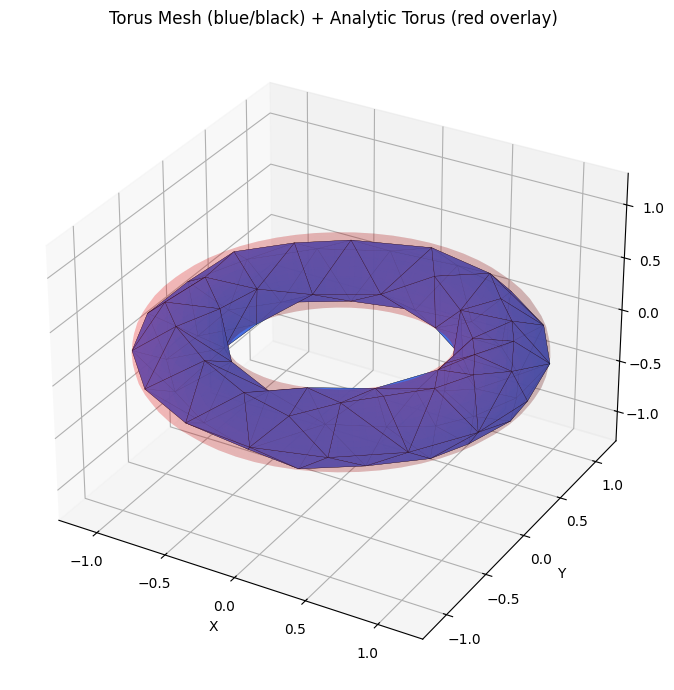

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# Draw mesh triangles: blue surface, black edges
for tri in faces:
    verts = points[tri]
    poly = Poly3DCollection([verts], alpha=0.8, facecolor='royalblue', edgecolor='k', linewidths=0.2)
    ax.add_collection3d(poly)

# ---- Analytic Torus Geometry Overlay ----
u = np.linspace(0, 2*np.pi, 60)
v_surface = np.linspace(0, 2*np.pi, 24)
u, v_surface = np.meshgrid(u, v_surface)
R = R_MAJOR
r = r_MINOR
x = (R + r * np.cos(v_surface)) * np.cos(u)
y = (R + r * np.cos(v_surface)) * np.sin(u)
z = r * np.sin(v_surface)
ax.plot_surface(
    x, y, z, color='red', alpha=0.14, rstride=1, cstride=1, linewidth=0, zorder=0
)

# Keep original aspect ratio
xyz_min = points.min(axis=0)
xyz_max = points.max(axis=0)
xyz_range = xyz_max - xyz_min
max_range = xyz_range.max()
mid = (xyz_max + xyz_min) / 2

for i, axis in enumerate(['x', 'y', 'z']):
    getattr(ax, f'set_{axis}lim')(mid[i] - max_range/2, mid[i] + max_range/2)

ax.set_title("Torus Mesh (blue/black) + Analytic Torus (red overlay)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()


In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import root
import multiprocessing
import time
import meshio
from tqdm import tqdm
import numpy as np
import numpy as np
from scipy.integrate import quad
!pip install joblib
from joblib import Parallel, delayed
R_MAJOR = 1.0
r_MINOR = 0.3
n_major = 12
n_minor = 6
tol = 1e-4
max_depth = 6
# Import functions from your Torus_lib.py (make sure it’s in the same folder)
from Torus_lib import *

if __name__ == "__main__":
    mesh_filename = "torus_tet_coarse.msh"
    mesh = meshio.read(mesh_filename)
    points = mesh.points
    cells = mesh.cells_dict
    faces = cells["triangle"] if "triangle" in cells else []
    tet_cells = cells["tetra"] if "tetra" in cells else []

    print(f"Loaded mesh: {mesh_filename}")
    print(f"Number of surface triangles: {len(faces)}")
    print(f"Number of tetrahedra: {len(tet_cells)}")

    # --- Piecewise linear (PL) volume over all tetrahedra ---
    V_piecewise = 0.0
    for tet in tet_cells:
        pts4 = points[tet]
        V_piecewise += tet_volume(pts4)

    # --- Patch/curved volume ---
    V_theory = torus_theoretical_volume(R_MAJOR, r_MINOR)
    print(f"Torus theoretical volume: {V_theory:.8f}")


    args_list = [(idx, tri, points, tol, max_depth) for idx, tri in enumerate(faces)]
    print(f"Using {multiprocessing.cpu_count()} CPU cores...")

    t0 = time.time()
    with multiprocessing.Pool() as pool:
        results = list(tqdm(pool.imap(adaptive_triangle_worker, args_list), total=len(args_list)))
    csv_rows = []
    V_patch_sum = 0.0
    for row, volume in results:
        csv_rows.append(row)
        V_patch_sum += volume
    df = pd.DataFrame(csv_rows)
    df.to_csv("adaptive_triangle_patch_correction.csv", index=False)
    print("\nWrote triangle patch corrections to adaptive_triangle_patch_correction.csv")
    t1 = time.time()

    rel_error_patchsum = (V_patch_sum + V_piecewise - V_theory) / V_theory * 100
    rel_error_piecewise = (V_piecewise - V_theory) / V_theory * 100
    V_patchsum_solidangle = sum(
        row['Vcorrection'][1] if isinstance(row['Vcorrection'], tuple) else row['Vcorrection']
        for row, _ in results
    )
    rel_error_patchsum_solidangle = (V_patchsum_solidangle + V_piecewise - V_theory) / V_theory * 100

    print(f"\n==== VOLUME SUMMARY ====")
    print(f"Theoretical value (torus):            {V_theory:.8f}")
    print(f"Piecewise sum of all tets:            {V_piecewise:.8f}")    
    print(f"Patch-based total (adaptive integral patch): {V_patch_sum:.8f}")

    print(f"Number of torus surface triangles:    {len(faces)}")
    print(f"Relative error (adaptive integral patch):    {rel_error_patchsum:.6f}%")
    print(f"Relative error (piecewise tets):      {rel_error_piecewise:.6f}%")
    print(f"Elapsed time (patch sum):             {t1-t0:.2f} s")

    print(f"\n==== VOLUME SUMMARY Solid Angle ====")
    print(f"Theoretical value (torus):            {V_theory:.8f}")
    print(f"Piecewise sum of all tets:            {V_piecewise:.8f}")
    print(f"Patch-based total (solid angle patch):  {V_patchsum_solidangle:.8f}")
    print(f"Number of torus surface triangles:    {len(faces)}")
    print(f"Relative error (solid angle patch):     {rel_error_patchsum_solidangle:.6f}%")
    print(f"Elapsed time (patch sum):             {t1-t0:.2f} s")



Loaded mesh: torus_tet_coarse.msh
Number of surface triangles: 160
Number of tetrahedra: 167
Torus theoretical volume: 1.77652879
Using 10 CPU cores...


100%|██████████| 160/160 [01:01<00:00,  2.58it/s]


Wrote triangle patch corrections to adaptive_triangle_patch_correction.csv

==== VOLUME SUMMARY ====
Theoretical value (torus):            1.77652879
Piecewise sum of all tets:            1.29737695
Patch-based total (adaptive integral patch): 0.48227544
Number of torus surface triangles:    160
Relative error (adaptive integral patch):    0.175826%
Relative error (piecewise tets):      -26.971240%
Elapsed time (patch sum):             62.04 s

==== VOLUME SUMMARY Solid Angle ====
Theoretical value (torus):            1.77652879
Piecewise sum of all tets:            1.29737695
Patch-based total (solid angle patch):  0.47908473
Number of torus surface triangles:    160
Relative error (solid angle patch):     -0.003778%
Elapsed time (patch sum):             62.04 s
